In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!mkdir "/content/COVID_Xray/"

In [3]:
!unzip "/content/drive/My Drive/COVID/Dataset/train.zip" -d /content/COVID_Xray/

Archive:  /content/drive/My Drive/COVID/Dataset/train.zip
   creating: /content/COVID_Xray/train/Covid/
  inflating: /content/COVID_Xray/train/Covid/Covid_1.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_10.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_100.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_101.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_102.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_103.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_104.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_105.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_106.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_107.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_108.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_109.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_11.png  
  inflating: /content/COVID_Xray/train/Covid/Covid_110.png  
  inflating: /content/COVID_Xray/train/Covid/C

In [4]:
!unzip "/content/drive/My Drive/COVID/Dataset/test.zip" -d /content/COVID_Xray/

Archive:  /content/drive/My Drive/COVID/Dataset/test.zip
   creating: /content/COVID_Xray/test/Covid/
  inflating: /content/COVID_Xray/test/Covid/Covid_709.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_710.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_711.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_712.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_713.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_714.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_715.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_716.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_717.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_718.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_719.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_720.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_721.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_722.png  
  inflating: /content/COVID_Xray/test/Covid/Covid_723.png 

In [5]:
import os
from os.path import basename, join, exists

In [6]:
os.chdir(r"/content/COVID_Xray/")

In [7]:
ls

test/  train/


In [8]:
train_dir="train/"
test_dir="test/"

total=0
print('---Training set details----')
for sub_folder in os.listdir(train_dir):
  no_of_images=len(os.listdir(train_dir + sub_folder))
  total+=no_of_images
  print(str(no_of_images) + " " + sub_folder + " images")

print("Total no. of Chest Xray training images=",total)

---Training set details----
1599 Normal images
712 Covid images
1544 Pneumonia images
Total no. of Chest Xray training images= 3855


In [9]:
total=0
print('---Test set details----')
for sub_folder in os.listdir(test_dir):
  no_of_images=len(os.listdir(test_dir + sub_folder))
  total+=no_of_images
  print(str(no_of_images) + " " + sub_folder + " images")

print("Total no. of Chest Xray test images=",total)

---Test set details----
40 Normal images
40 Covid images
40 Pneumonia images
Total no. of Chest Xray test images= 120


In [10]:
!mkdir "/content/COVID_Xray/extracted_features/"

In [11]:
extracted_features_dir="/content/COVID_Xray/extracted_features/"

In [12]:
import numpy as np
np.random.seed(777)
import time
import keras as keras
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from keras.layers import merge,Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator
# DCNN Models used
#---------------------------------------------
from keras.applications.inception_v3 import InceptionV3
#----------------------------------------------
from keras.applications.vgg16 import preprocess_input as pi_vgg16
from keras.applications.vgg19 import preprocess_input as pi_vgg19
from keras.applications.xception import preprocess_input as pi_xcep 
from keras.applications.inception_resnet_v2 import preprocess_input as pi_incepresnet
from keras.models import load_model
from numpy import array
from numpy import argmax
from sklearn.metrics import accuracy_score
from  numpy import mean 
from numpy import std
import matplotlib.pyplot as plt
from keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Concatenate
from keras.layers import BatchNormalization,Dropout
from keras.layers import Lambda
from keras.regularizers import l2
import math
from keras import backend as K
from keras.metrics import categorical_accuracy
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.models import load_model

In [13]:
img_height =512
img_width = 512
batch_size =32
input_shape = (img_width, img_height, 3)

In [14]:
print("-----------------Image Augmentation for VGG19--------------")

random_seed = np.random.seed(1142)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split= 0.2,
    zoom_range=0.1,
    shear_range=0.2)

train_generator_incep = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'training',
    class_mode='categorical')

val_generator_incep = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'validation',
    class_mode='categorical')

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator_incep=test_datagen.flow_from_directory(test_dir,
                                                      target_size=(img_height, img_width),
                                                          batch_size=batch_size, 
                                                          seed=random_seed,
                                                          shuffle=False,
                                                          class_mode='categorical') 



-----------------Image Augmentation for VGG19--------------
Found 3086 images belonging to 3 classes.
Found 769 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [15]:

nb_train_samples = len(train_generator_incep.filenames)
nb_validation_samples = len(val_generator_incep.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator_incep.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))
print(nb_train_samples)
print(nb_validation_samples)
print(nb_test_samples)
print(predict_size_train)
print(predict_size_validation)
print(predict_size_test)

3086
769
120
97
25
4


In [ ]:
model_name="InceptionV3"
model = InceptionV3(include_top=False, weights="imagenet",pooling='avg',input_shape=input_shape)
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
image_input =model.input
x1 = GlobalAveragePooling2D()(model.get_layer("conv2d_3").output) #layer_11
x2 = GlobalAveragePooling2D()(model.get_layer("conv2d_8").output) #layer_18
x3 = GlobalAveragePooling2D()(model.get_layer("conv2d_5").output)  #layer_28
x4= GlobalAveragePooling2D()(model.get_layer("conv2d_12").output) #layer_51
x5= GlobalAveragePooling2D()(model.get_layer("conv2d_19").output) #layer_74
x6= GlobalAveragePooling2D()(model.get_layer("conv2d_34").output) #layer_101
x7= GlobalAveragePooling2D()(model.get_layer("conv2d_30").output) #layer_120
x8= GlobalAveragePooling2D()(model.get_layer("conv2d_40").output) #layer_152
x9= GlobalAveragePooling2D()(model.get_layer("conv2d_50").output) #layer_184
x10= GlobalAveragePooling2D()(model.get_layer("conv2d_60").output)#layer_216
x11= GlobalAveragePooling2D()(model.get_layer("conv2d_80").output) #layer_249
x12= GlobalAveragePooling2D()(model.get_layer("conv2d_76").output) #layer_263
x13= GlobalAveragePooling2D()(model.get_layer("conv2d_85").output)#layer_294
out= Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13])
custom_incep_model = Model(image_input , out)
custom_incep_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
for i, layer in enumerate(custom_incep_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [ ]:
for layer in custom_incep_model.layers[:249]:
    layer.trainable = False
custom_incep_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Saving features of the training images
bottleneck_features_train = custom_incep_model.predict_generator(train_generator_incep, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [ ]:
# Saving features of the validation images
bottleneck_features_validation = custom_incep_model.predict_generator(val_generator_incep, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [ ]:
# Saving features of the test images
bottleneck_features_test = custom_incep_model.predict_generator(test_generator_incep, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [ ]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

In [ ]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(3086, 2320)
(769, 2320)
(120, 2320)


In [ ]:
train_labels=train_generator_incep.classes
train_labels= keras.utils.to_categorical(train_labels, num_classes=3)
validation_labels=val_generator_incep.classes
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=3)
test_labels=test_generator_incep.classes
test_labels=keras.utils.to_categorical(test_labels,num_classes=3)

In [ ]:
print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)

(3086, 3)
(769, 3)
(120, 3)


In [ ]:

model = Sequential()
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax',name= 'output'))

adam_opt=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8,amsgrad=True)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)


Epoch 1/1000
97/97 - 1s - loss: 0.8535 - accuracy: 0.6688 - val_loss: 0.4747 - val_accuracy: 0.8466
Epoch 2/1000
97/97 - 0s - loss: 0.4851 - accuracy: 0.8140 - val_loss: 0.3993 - val_accuracy: 0.8557
Epoch 3/1000
97/97 - 0s - loss: 0.4400 - accuracy: 0.8240 - val_loss: 0.3710 - val_accuracy: 0.8635
Epoch 4/1000
97/97 - 0s - loss: 0.4105 - accuracy: 0.8445 - val_loss: 0.3980 - val_accuracy: 0.8375
Epoch 5/1000
97/97 - 0s - loss: 0.3982 - accuracy: 0.8464 - val_loss: 0.3891 - val_accuracy: 0.8401
Epoch 6/1000
97/97 - 0s - loss: 0.3853 - accuracy: 0.8490 - val_loss: 0.5112 - val_accuracy: 0.8127
Epoch 7/1000
97/97 - 0s - loss: 0.3690 - accuracy: 0.8597 - val_loss: 0.3376 - val_accuracy: 0.8635
Epoch 8/1000
97/97 - 0s - loss: 0.3618 - accuracy: 0.8558 - val_loss: 0.3672 - val_accuracy: 0.8700
Epoch 9/1000
97/97 - 0s - loss: 0.3527 - accuracy: 0.8577 - val_loss: 0.3310 - val_accuracy: 0.8622
Epoch 10/1000
97/97 - 0s - loss: 0.3531 - accuracy: 0.8613 - val_loss: 0.3416 - val_accuracy: 0.8609

In [ ]:
preds = model.predict(validation_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in validation_labels]
print('Validation Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Validation Accuracy=0.9219765929778934


In [ ]:

preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
print('Test Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Test Accuracy=0.925


In [ ]:
model.save('/content/drive/My Drive/COVID/saved models/InceptionV3/covid_inception_input_dim_{}_fine_tuning_{}.h5'.format(512,17))
model.save_weights('/content/drive/My Drive/COVID/saved models/InceptionV3/covid_inception_input_dim_{}_fine_tuning_{}_weights.h5'.format(512,17))

In [16]:
loaded_model=load_model('/content/drive/My Drive/COVID/saved models/InceptionV3/covid_inception_input_dim_512_fine_tuning_17.h5',compile=False)
loaded_model.load_weights('/content/drive/My Drive/COVID/saved models/InceptionV3/covid_inception_input_dim_512_fine_tuning_17_weights.h5')

In [ ]:
train_data
validation_data=np.load('/content/drive/MyDrive/COVID/Feature Extraction/InceptionV3/InceptionV3_val_features.npy')
test_data=np.load('/content/drive/MyDrive/COVID/Feature Extraction/InceptionV3/InceptionV3_test_features.npy')

In [ ]:
validation_labels=val_generator_incep.classes
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=3)
test_labels=test_generator_incep.classes
test_labels=keras.utils.to_categorical(test_labels,num_classes=3)

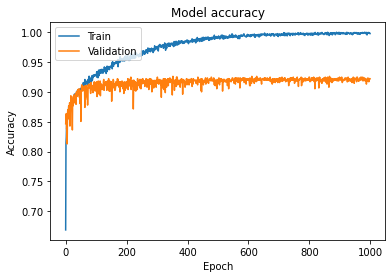

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

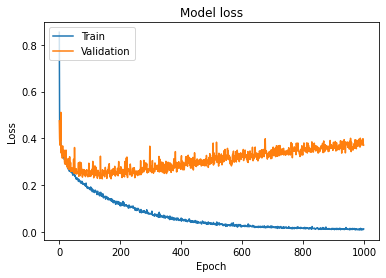

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

In [ ]:
preds = loaded_model.predict(validation_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in validation_labels]
print('Validation Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Validation Accuracy=0.9219765929778934


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns
import pandas as pd

In [ ]:
preds = loaded_model.predict(test_data)

y_pred = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=y_pred, y_true=y_true)

print('Test Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=y_pred)))

Test Accuracy=0.925


In [ ]:
for i in y_pred:
  print(i,end=",")

2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,

CONFUSION MATRIX


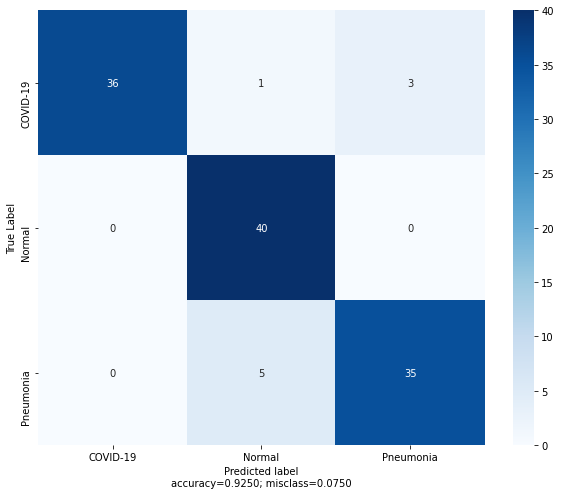

The details for confusion matrix is =
              precision    recall  f1-score   support

    COVID-19       1.00      0.90      0.95        40
      Normal       0.87      1.00      0.93        40
   Pneumonia       0.92      0.88      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.92      0.93       120
weighted avg       0.93      0.93      0.93       120



In [ ]:
print('CONFUSION MATRIX')
conf_matrix = pd.DataFrame(data = cm,  
                           columns = ['COVID-19','Normal','Pneumonia'],  
                           index =['COVID-19','Normal','Pneumonia']) 

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
plt.figure(figsize = (10,8)) 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues") 
plt.ylabel('True Label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show() 

target_names=['COVID-19','Normal','Pneumonia']
print('The details for confusion matrix is =') 
print (classification_report(y_true, y_pred,target_names=target_names))

In [ ]:
import pandas as pd
test_df=pd.read_csv('/content/drive/My Drive/COVID/Confidence_matrix.csv')
test_df

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16_class0,vgg16_class1,vgg16_class2,xception_class0,xception_class1,xception_class2
0,0,0,0,9.997659e-01,1.618086e-11,2.340811e-04,9.994861e-01,2.525695e-12,5.139261e-04
1,1,1,0,1.000000e+00,3.336014e-15,3.459131e-09,9.997345e-01,6.661170e-15,2.654911e-04
2,2,2,0,1.000000e+00,4.013379e-14,3.260767e-12,1.000000e+00,1.820434e-15,3.275297e-08
3,3,3,0,9.986774e-01,1.859167e-06,1.320634e-03,3.295750e-01,1.761833e-04,6.702489e-01
4,4,4,0,4.096806e-01,3.651214e-02,5.538073e-01,2.901666e-01,6.982374e-01,1.159600e-02
...,...,...,...,...,...,...,...,...,...
115,115,115,2,5.289370e-13,1.708974e-02,9.829102e-01,2.985189e-13,2.784816e-03,9.972152e-01
116,116,116,2,4.523590e-13,1.193429e-02,9.880657e-01,1.305408e-08,5.878432e-02,9.412156e-01
117,117,117,2,1.754031e-13,9.999989e-01,1.128248e-06,1.004209e-12,9.974482e-01,2.551764e-03
118,118,118,2,3.275368e-11,5.605959e-06,9.999944e-01,4.922030e-12,5.157485e-12,1.000000e+00


In [ ]:
conf_score= loaded_model.predict(test_data)
for i in range(0,3):
  test_df['inception_class'+str(i)]=conf_score[:,i]
test_df

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16_class0,vgg16_class1,vgg16_class2,xception_class0,xception_class1,xception_class2,inception_class0,inception_class1,inception_class2
0,0,0,0,9.997659e-01,1.618086e-11,2.340811e-04,9.994861e-01,2.525695e-12,5.139261e-04,4.200792e-01,1.592607e-05,5.799049e-01
1,1,1,0,1.000000e+00,3.336014e-15,3.459131e-09,9.997345e-01,6.661170e-15,2.654911e-04,9.999992e-01,2.012152e-11,8.077652e-07
2,2,2,0,1.000000e+00,4.013379e-14,3.260767e-12,1.000000e+00,1.820434e-15,3.275297e-08,9.999908e-01,1.250993e-09,9.147426e-06
3,3,3,0,9.986774e-01,1.859167e-06,1.320634e-03,3.295750e-01,1.761833e-04,6.702489e-01,9.952814e-01,8.489763e-04,3.869608e-03
4,4,4,0,4.096806e-01,3.651214e-02,5.538073e-01,2.901666e-01,6.982374e-01,1.159600e-02,1.593611e-02,9.292941e-01,5.476975e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,115,2,5.289370e-13,1.708974e-02,9.829102e-01,2.985189e-13,2.784816e-03,9.972152e-01,3.864901e-13,9.656610e-02,9.034339e-01
116,116,116,2,4.523590e-13,1.193429e-02,9.880657e-01,1.305408e-08,5.878432e-02,9.412156e-01,6.125274e-09,5.998192e-01,4.001807e-01
117,117,117,2,1.754031e-13,9.999989e-01,1.128248e-06,1.004209e-12,9.974482e-01,2.551764e-03,6.080916e-12,9.999990e-01,9.157010e-07
118,118,118,2,3.275368e-11,5.605959e-06,9.999944e-01,4.922030e-12,5.157485e-12,1.000000e+00,2.001285e-12,2.615448e-06,9.999974e-01


In [ ]:
test_df.to_csv('/content/drive/My Drive/COVID/Confidence_matrix.csv')

In [ ]:
test_df=pd.read_csv('/content/drive/My Drive/COVID/Confidence_matrix.csv')
test_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,True Label,vgg16_class0,vgg16_class1,vgg16_class2,xception_class0,xception_class1,xception_class2,inception_class0,inception_class1,inception_class2
0,0,0,0,0,9.997659e-01,1.618086e-11,2.340811e-04,9.994861e-01,2.525695e-12,5.139261e-04,4.200792e-01,1.592607e-05,5.799049e-01
1,1,1,1,0,1.000000e+00,3.336014e-15,3.459131e-09,9.997345e-01,6.661170e-15,2.654911e-04,9.999992e-01,2.012152e-11,8.077652e-07
2,2,2,2,0,1.000000e+00,4.013379e-14,3.260767e-12,1.000000e+00,1.820434e-15,3.275297e-08,9.999908e-01,1.250993e-09,9.147426e-06
3,3,3,3,0,9.986774e-01,1.859167e-06,1.320634e-03,3.295750e-01,1.761833e-04,6.702489e-01,9.952814e-01,8.489762e-04,3.869608e-03
4,4,4,4,0,4.096806e-01,3.651214e-02,5.538073e-01,2.901666e-01,6.982374e-01,1.159600e-02,1.593611e-02,9.292941e-01,5.476975e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,115,115,2,5.289370e-13,1.708974e-02,9.829102e-01,2.985189e-13,2.784816e-03,9.972152e-01,3.864901e-13,9.656610e-02,9.034339e-01
116,116,116,116,2,4.523590e-13,1.193429e-02,9.880657e-01,1.305408e-08,5.878432e-02,9.412156e-01,6.125274e-09,5.998192e-01,4.001807e-01
117,117,117,117,2,1.754031e-13,9.999989e-01,1.128248e-06,1.004209e-12,9.974482e-01,2.551764e-03,6.080916e-12,9.999991e-01,9.157010e-07
118,118,118,118,2,3.275368e-11,5.605959e-06,9.999944e-01,4.922030e-12,5.157485e-12,1.000000e+00,2.001285e-12,2.615448e-06,9.999974e-01


In [ ]:
test_df=test_df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)
test_df

,True Label,vgg16_class0,vgg16_class1,vgg16_class2,xception_class0,xception_class1,xception_class2,inception_class0,inception_class1,inception_class2
0,0,9.997659e-01,1.618086e-11,2.340811e-04,9.994861e-01,2.525695e-12,5.139261e-04,4.200792e-01,1.592607e-05,5.799049e-01
1,0,1.000000e+00,3.336014e-15,3.459131e-09,9.997345e-01,6.661170e-15,2.654911e-04,9.999992e-01,2.012152e-11,8.077652e-07
2,0,1.000000e+00,4.013379e-14,3.260767e-12,1.000000e+00,1.820434e-15,3.275297e-08,9.999908e-01,1.250993e-09,9.147426e-06
3,0,9.986774e-01,1.859167e-06,1.320634e-03,3.295750e-01,1.761833e-04,6.702489e-01,9.952814e-01,8.489762e-04,3.869608e-03
4,0,4.096806e-01,3.651214e-02,5.538073e-01,2.901666e-01,6.982374e-01,1.159600e-02,1.593611e-02,9.292941e-01,5.476975e-02
...,...,...,...,...,...,...,...,...,...,...
115,2,5.289370e-13,1.708974e-02,9.829102e-01,2.985189e-13,2.784816e-03,9.972152e-01,3.864901e-13,9.656610e-02,9.034339e-01
116,2,4.523590e-13,1.193429e-02,9.880657e-01,1.305408e-08,5.878432e-02,9.412156e-01,6.125274e-09,5.998192e-01,4.001807e-01
117,2,1.754031e-13,9.999989e-01,1.128248e-06,1.004209e-12,9.974482e-01,2.551764e-03,6.080916e-12,9.999991e-01,9.157010e-07
118,2,3.275368e-11,5.605959e-06,9.999944e-01,4.922030e-12,5.157485e-12,1.000000e+00,2.001285e-12,2.615448e-06,9.999974e-01


In [ ]:
test_df.to_csv('/content/drive/My Drive/COVID/Confidence_matrix.csv')

In [ ]:
import pandas as pd
val_df=pd.read_csv('/content/drive/My Drive/COVID/Val_Prediction_matrix.csv')
val_df

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16,xception
0,0,0,0,0,0
1,1,1,0,0,0
2,2,2,0,0,0
3,3,3,0,0,0
4,4,4,0,0,0
...,...,...,...,...,...
764,764,764,2,2,2
765,765,765,2,2,2
766,766,766,2,2,2
767,767,767,2,2,2


In [ ]:
preds = loaded_model.predict(validation_data)
predictions = [i.argmax() for i in preds]
val_df['inception']=predictions
val_df

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16,xception,inception
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,2,2,0,0,0,0
3,3,3,0,0,0,0
4,4,4,0,0,0,0
...,...,...,...,...,...,...
764,764,764,2,2,2,2
765,765,765,2,2,2,2
766,766,766,2,2,2,2
767,767,767,2,2,2,2


In [ ]:
val_df.to_csv('/content/drive/My Drive/COVID/Val_Prediction_matrix.csv')

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16,xception,inception
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,2,2,0,0,0,0
3,3,3,0,0,0,0
4,4,4,0,0,0,0
...,...,...,...,...,...,...
764,764,764,2,2,2,2
765,765,765,2,2,2,2
766,766,766,2,2,2,2
767,767,767,2,2,2,2


In [ ]:
val_df=pd.read_csv('/content/drive/My Drive/COVID/Val_Prediction_matrix.csv')
val_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,True Label,vgg16,xception,inception
0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0
2,2,2,2,0,0,0,0
3,3,3,3,0,0,0,0
4,4,4,4,0,0,0,0
...,...,...,...,...,...,...,...
764,764,764,764,2,2,2,2
765,765,765,765,2,2,2,2
766,766,766,766,2,2,2,2
767,767,767,767,2,2,2,2


In [ ]:
val_df=val_df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)
val_df

,True Label,vgg16,xception,inception
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
764,2,2,2,2
765,2,2,2,2
766,2,2,2,2
767,2,2,2,2


In [ ]:
val_df.to_csv('/content/drive/My Drive/COVID/Val_Prediction_matrix.csv')

In [ ]:
test_df=pd.read_csv('/content/drive/My Drive/COVID/Test_Prediction_matrix.csv')
test_df

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16,xception
0,0,0,0,0,0
1,1,1,0,0,0
2,2,2,0,0,0
3,3,3,0,0,2
4,4,4,0,2,1
...,...,...,...,...,...
115,115,115,2,2,2
116,116,116,2,2,2
117,117,117,2,1,1
118,118,118,2,2,2


In [ ]:
preds = loaded_model.predict(test_data)
predictions = [i.argmax() for i in preds]
test_df['inception']=predictions
test_df

,Unnamed: 0,Unnamed: 0.1,True Label,vgg16,xception,inception
0,0,0,0,0,0,2
1,1,1,0,0,0,0
2,2,2,0,0,0,0
3,3,3,0,0,2,0
4,4,4,0,2,1,1
...,...,...,...,...,...,...
115,115,115,2,2,2,2
116,116,116,2,2,2,1
117,117,117,2,1,1,1
118,118,118,2,2,2,2


In [ ]:
test_df.to_csv('/content/drive/My Drive/COVID/Test_Prediction_matrix.csv')

In [ ]:
test_df=pd.read_csv('/content/drive/My Drive/COVID/Test_Prediction_matrix.csv')
test_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,True Label,vgg16,xception,inception
0,0,0,0,0,0,0,2
1,1,1,1,0,0,0,0
2,2,2,2,0,0,0,0
3,3,3,3,0,0,2,0
4,4,4,4,0,2,1,1
...,...,...,...,...,...,...,...
115,115,115,115,2,2,2,2
116,116,116,116,2,2,2,1
117,117,117,117,2,1,1,1
118,118,118,118,2,2,2,2


In [ ]:
test_df=test_df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)
test_df

,True Label,vgg16,xception,inception
0,0,0,0,2
1,0,0,0,0
2,0,0,0,0
3,0,0,2,0
4,0,2,1,1
...,...,...,...,...
115,2,2,2,2
116,2,2,2,1
117,2,1,1,1
118,2,2,2,2


In [ ]:
test_df.to_csv('/content/drive/My Drive/COVID/Test_Prediction_matrix.csv')